# Mediod Playground
Testing out some mediod calculations.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import xray
import numpy
import datacube.api
import dask
dask.set_options(get=dask.async.get_sync)

In [16]:
api = datacube.api.API()

In [17]:
descriptor_request = {
    'satellite': 'LANDSAT_8',
    'product': 'EODS_NBAR',
}
descriptor = api.get_descriptor(descriptor_request)
variables = descriptor.values()[0]['variables'].keys()
variables

[u'band_6', u'band_7', u'band_4', u'band_5', u'band_2', u'band_3', u'band_1']

In [4]:
data_request = {
    'satellite': 'LANDSAT_8',
    'product': 'EODS_NBAR',
    'variables': variables,
    'dimensions': {
        'latitude': {
            'range': (-35.2,-35.3)
        },
        'longitude': {
            'range': (149.01,149.21)
        }
    }
}
data = api.get_data(data_request)

In [5]:
data_request

{'dimensions': {'latitude': {'range': (-35.2, -35.3)},
  'longitude': {'range': (149.01, 149.21)}},
 'product': 'EODS_NBAR',
 'satellite': 'LANDSAT_8',
 'variables': [u'band_6',
  u'band_7',
  u'band_4',
  u'band_5',
  u'band_2',
  u'band_3',
  u'band_1']}

In [6]:
data['arrays'].keys()

[u'band_6', u'band_7', u'band_4', u'band_5', u'band_2', u'band_3', u'band_1']

In [7]:
band_red = data['arrays']['band_4']
band_red.shape

(17, 401, 801)

We can select the first time slice by index

In [8]:
band_nir = data['arrays']['band_5']
band_nir.isel(time=0).shape

(401, 801)

Plot it using matplotlib

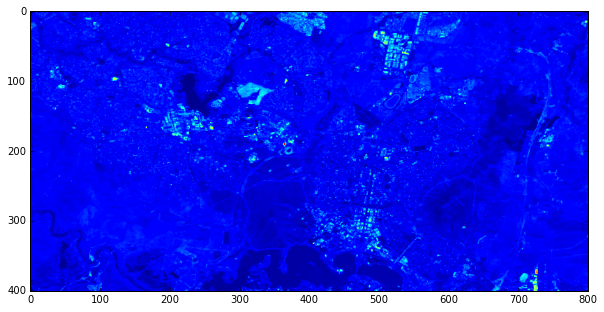

In [9]:
plt.figure(figsize=(10,7))
plt.imshow(band_red.isel(time=0))

Near Infraread looks pretty cool

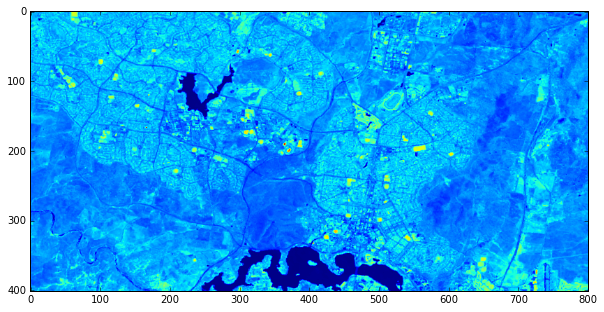

In [10]:
plt.figure(figsize=(10,7))
plt.imshow(band_nir.isel(time=0))

In [11]:
ndvi = (band_nir - band_red) / (band_nir + band_red * 1.)

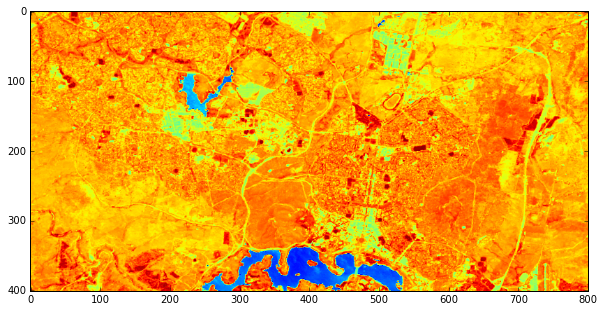

In [12]:
plt.figure(figsize=(10,7))
plt.imshow(ndvi.isel(time=0))

In [13]:
seasonal_groups = ndvi.groupby('time.season')
seasonal_groups.groups

{'DJF': [0, 1, 2],
 'JJA': [8, 9, 10, 11, 12, 13],
 'MAM': [3, 4, 5, 6, 7],
 'SON': [14, 15, 16]}

In [14]:
seasonal = seasonal_groups.apply(xray.DataArray.mean, dim='time').load()

IndexError: too many indices for array

In [ ]:
plt.imshow(seasonal.sel(season='DJF'))

In [ ]:
seasonal.sel(season='JJA').plot()

In [ ]:
seasonal.sel(season='MAM').plot()

We can also query a location across time

In [ ]:
pixel_drill = data['arrays']['band_1'].sel(latitude=-35.53, longitude=148.76)
pixel_drill.values

In [ ]:
pixel_drill.load()
plt.figure(figsize=(12,8))
pixel_drill.plot()
plt.show()

Or do something a tille more involved.

In [ ]:
band_1 = data['arrays']['band_1']
    band_4 = data['arrays']['band_4']
    band_6 = data['arrays']['band_6']

    band_1_mean = band_1.mean(axis=0)
    band_4_mean = band_4.mean(axis=0)
    band_6_mean = band_6.mean(axis=0)

    band_1_scaled = (band_1_mean - band_1_mean.min()) / float(band_1_mean.max() - band_1_mean.min())
    band_4_scaled = (band_4_mean - band_4_mean.min()) / float(band_4_mean.max() - band_4_mean.min())
    band_6_scaled = (band_6_mean - band_6_mean.min()) / float(band_6_mean.max() - band_6_mean.min())

    rgb = xray.concat([band_6_scaled, band_4_scaled, band_1_scaled], 'color')
    rgb = rgb.transpose('latitude', 'longitude', 'color')
    
    plt.figure(figsize=(10,8))
    plt.imshow(rgb.sel(latitude=slice(-35.2,-35.6), longitude=slice(148.9, 149.3)))